<a href="https://colab.research.google.com/github/Vivek29112001/Machine-Learning-Projects/blob/main/ML_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1 import utils

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import os
import warnings
warnings.filterwarnings("ignore")

def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


In [6]:
train_path = "bike_train.csv"
test_path  = "bike_test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test  shape:", test.shape)
print("\nTrain columns:", train.columns.to_list())
print("\nMissing values (train):\n", train.isnull().sum())
print("\nMissing values (test):\n", test.isnull().sum())

# Peek at data
display(train.head())
display(test.head())

Train shape: (10450, 12)
Test  shape: (2613, 9)

Train columns: ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

Missing values (train):
 datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Missing values (test):
 datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 7:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 6:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:02,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 2:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,05-06-2012 5:00,2,0,1,3,19.680000,23.48500,82,11.00140
1,19-03-2011 19:00,1,0,0,1,18.040000,21.97000,33,19.00120
2,02-04-2012 6:00,2,0,1,1,13.885038,16.24664,68,29.52646
3,13-07-2012 20:00,3,0,1,1,30.340000,33.33500,48,8.99810
4,09-11-2011 19:00,4,0,1,1,18.040000,21.97000,72,7.00150


## Step2-> EDA Plots

0   2012-07-15 07:00:00
1   2012-08-14 15:00:00
2   2011-02-06 06:00:00
3   2012-05-06 17:00:02
4   2012-01-09 02:00:00
Name: datetime, dtype: datetime64[ns]
0   2012-06-05 05:00:00
1   2011-03-19 19:00:00
2   2012-04-02 06:00:00
3   2012-07-13 20:00:00
4   2011-11-09 19:00:00
Name: datetime, dtype: datetime64[ns]


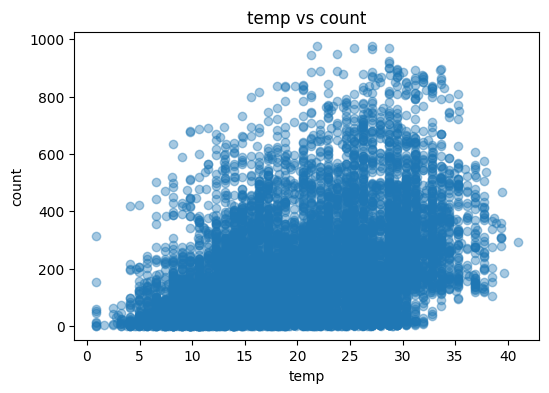

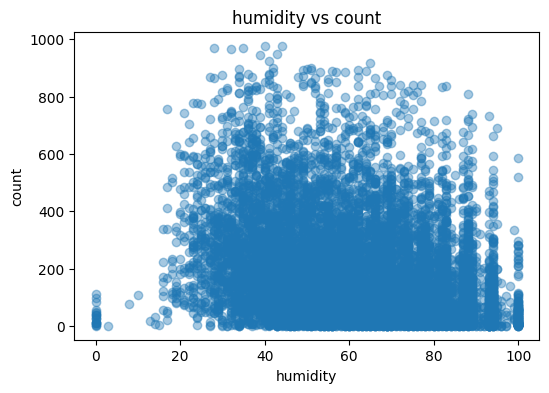

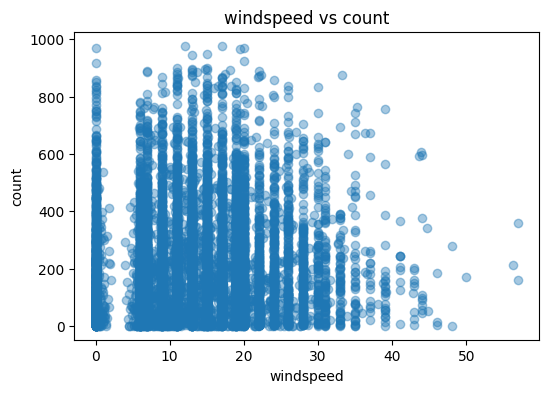

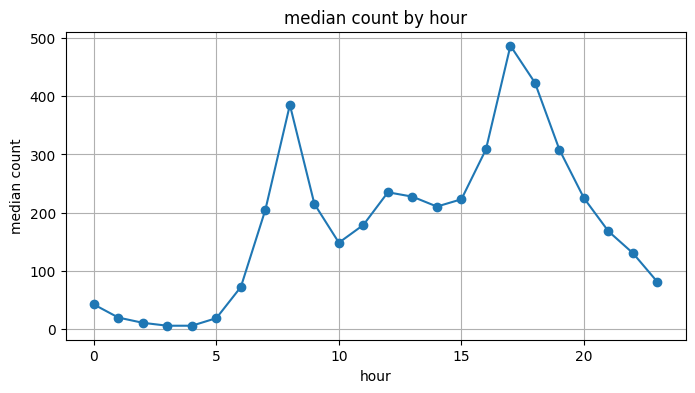

In [7]:
train['datetime'] = pd.to_datetime(train['datetime'], errors='coerce')
test['datetime'] = pd.to_datetime(test['datetime'], format="%d-%m-%Y %H:%M", errors='coerce')

print(train['datetime'].head())
print(test['datetime'].head())

# scatter plots: temp, humidity, windspeed vs count
plt.figure(figsize=(6,4)); plt.scatter(train['temp'], train['count'], alpha=0.4); plt.xlabel('temp'); plt.ylabel('count'); plt.title('temp vs count'); plt.show()
plt.figure(figsize=(6,4)); plt.scatter(train['humidity'], train['count'], alpha=0.4); plt.xlabel('humidity'); plt.ylabel('count'); plt.title('humidity vs count'); plt.show()
plt.figure(figsize=(6,4)); plt.scatter(train['windspeed'], train['count'], alpha=0.4); plt.xlabel('windspeed'); plt.ylabel('count'); plt.title('windspeed vs count'); plt.show()

# median count by hour
train['hour'] = train['datetime'].dt.hour
med = train.groupby('hour')['count'].median()
plt.figure(figsize=(8,4)); plt.plot(med.index, med.values, marker='o'); plt.xlabel('hour'); plt.ylabel('median count'); plt.title('median count by hour'); plt.grid(); plt.show()


# Step 3: feature engineering

In [8]:

def add_datetime_features(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    return df

train = add_datetime_features(train)
test  = add_datetime_features(test)

# chosen features for modeling
base_features = ['temp','atemp','humidity','windspeed','hour','weekday','month','is_weekend']
# include season/weather if present
for c in ['season','weather']:
    if c in train.columns:
        base_features.append(c)

print("Features used:", base_features)


Features used: ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'weekday', 'month', 'is_weekend', 'season', 'weather']


# Step 4: prepare X and y (one-hot categorical)

In [9]:
use_features = [f for f in base_features if f in train.columns]

# concat train+test to get consistent dummies
all_df = pd.concat([train[use_features], test[use_features]], axis=0, ignore_index=True)

# categorical columns (season, weather) — make dummies if present
cat_cols = [c for c in ['season','weather'] if c in all_df.columns]
all_df = pd.get_dummies(all_df, columns=cat_cols, drop_first=True)

# split back
X_all = all_df.iloc[:len(train)].reset_index(drop=True)
X_test_all = all_df.iloc[len(train):].reset_index(drop=True)

y = train['count'].reset_index(drop=True)

print("X_all shape:", X_all.shape, "X_test shape:", X_test_all.shape)
display(X_all.head())


X_all shape: (10450, 14) X_test shape: (2613, 14)


,temp,atemp,humidity,windspeed,hour,weekday,month,is_weekend,season_2,season_3,season_4,weather_2,weather_3,weather_4
0,28.70000,33.335000,79,6.003200,7,6,7,1,False,True,False,False,False,False
1,33.62000,37.880000,46,15.001300,15,1,8,0,False,True,False,False,False,False
2,10.66000,12.880000,60,15.001300,6,6,2,1,False,False,False,False,False,False
3,26.42506,30.566166,61,9.512288,17,6,5,1,True,False,False,True,False,False
4,9.84000,12.120000,56,8.998100,2,0,1,0,False,False,False,False,False,False


# Step 5: split for validation


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y, test_size=0.2, random_state=42)
print("Train split:", X_train.shape, y_train.shape, "Val split:", X_val.shape, y_val.shape)


Train split: (8360, 14) (8360,) Val split: (2090, 14) (2090,)


# Step 6: Linear Regression (direct)


In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_val_lr = lr.predict(X_val)
print("LinearRegression RMSLE:", rmsle(y_val, pred_val_lr))


LinearRegression RMSLE: 1.2861105597394433


# Step 7: LinearRegression on log1p(target)


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr_log = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
lr_log.fit(X_train, np.log1p(y_train))
pred_val_log = np.expm1(lr_log.predict(X_val))   # invert log1p
print("LinearRegression (log-target) RMSLE:", rmsle(y_val, pred_val_log))


LinearRegression (log-target) RMSLE: 1.030480290654559


# Step 8: Polynomial degree 2 + Linear Regression


In [13]:
poly2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
poly2.fit(X_train, y_train)
pred_val_poly2 = poly2.predict(X_val)
print("Poly(deg2)+LR RMSLE:", rmsle(y_val, pred_val_poly2))


Poly(deg2)+LR RMSLE: 1.402281742850466


# Step 9: Polynomial + Ridge


In [14]:
pipe_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
gs_ridge = GridSearchCV(pipe_ridge, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_ridge.fit(X_train, y_train)
best_ridge = gs_ridge.best_estimator_
pred_val_ridge = best_ridge.predict(X_val)
print("Best Ridge alpha:", gs_ridge.best_params_)
print("Ridge (deg2) RMSLE:", rmsle(y_val, pred_val_ridge))


Best Ridge alpha: {'ridge__alpha': 10}
Ridge (deg2) RMSLE: 1.3825474234509458


# Step 10: Polynomial + Lasso with GridSearch


In [15]:
pipe_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])
param_grid_l = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
gs_lasso = GridSearchCV(pipe_lasso, param_grid_l, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_lasso.fit(X_train, y_train)
best_lasso = gs_lasso.best_estimator_
pred_val_lasso = best_lasso.predict(X_val)
print("Best Lasso alpha:", gs_lasso.best_params_)
print("Lasso (deg2) RMSLE:", rmsle(y_val, pred_val_lasso))


Best Lasso alpha: {'lasso__alpha': 0.1}
Lasso (deg2) RMSLE: 1.3916457024270157


# Step 11: collect results


In [16]:
results = [
    ("LinearRegression", rmsle(y_val, pred_val_lr)),
    ("LinearRegression_logTarget", rmsle(y_val, pred_val_log)),
    ("Poly(deg2)+LR", rmsle(y_val, pred_val_poly2)),
    (f"Ridge(deg2)_alpha={gs_ridge.best_params_['ridge__alpha']}", rmsle(y_val, pred_val_ridge)),
    (f"Lasso(deg2)_alpha={gs_lasso.best_params_['lasso__alpha']}", rmsle(y_val, pred_val_lasso))
]
results_df = pd.DataFrame(results, columns=['model','RMSLE']).sort_values('RMSLE').reset_index(drop=True)
display(results_df)


,model,RMSLE
0,LinearRegression_logTarget,1.030480
1,LinearRegression,1.286111
2,Ridge(deg2)_alpha=10,1.382547
3,Lasso(deg2)_alpha=0.1,1.391646
4,Poly(deg2)+LR,1.402282


# Step 12: pick best model (lowest RMSLE in results_df) and plot residuals


Best model: LinearRegression_logTarget


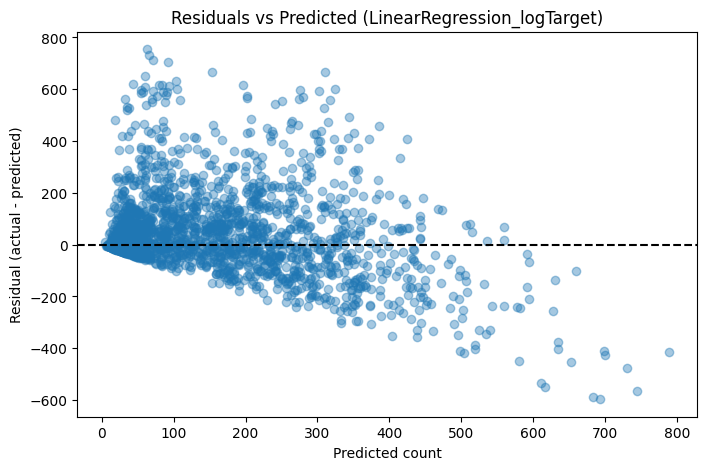

In [17]:
best_model_name = results_df.loc[0,'model']
print("Best model:", best_model_name)

# map name to model object
if best_model_name.startswith("Ridge"):
    chosen_model = best_ridge
elif best_model_name.startswith("Lasso"):
    chosen_model = best_lasso
elif best_model_name == "Poly(deg2)+LR":
    chosen_model = poly2
elif best_model_name == "LinearRegression_logTarget":
    chosen_model = lr_log
else:
    chosen_model = lr

# get predictions on validation and residuals
if best_model_name == "LinearRegression_logTarget":
    preds_val = np.expm1(chosen_model.predict(X_val))
else:
    preds_val = chosen_model.predict(X_val)

residuals = y_val - preds_val

plt.figure(figsize=(8,5))
plt.scatter(preds_val, residuals, alpha=0.4)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel("Predicted count"); plt.ylabel("Residual (actual - predicted)")
plt.title(f"Residuals vs Predicted ({best_model_name})")
plt.show()


## final creating csv file and saving it

In [19]:
if best_model_name == "LinearRegression_logTarget":
    final_model = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
    final_model.fit(X_all, np.log1p(y))
    test_preds = np.expm1(final_model.predict(X_test_all))
else:
    if best_model_name == "Poly(deg2)+LR":
        final_model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                                ('scaler', StandardScaler()),
                                ('lr', LinearRegression())])
        final_model.fit(X_all, y)
        test_preds = final_model.predict(X_test_all)
    elif best_model_name.startswith("Ridge"):
        alpha = gs_ridge.best_params_['ridge__alpha']
        final_model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                                ('scaler', StandardScaler()),
                                ('ridge', Ridge(alpha=alpha))])
        final_model.fit(X_all, y)
        test_preds = final_model.predict(X_test_all)
    elif best_model_name.startswith("Lasso"):
        alpha = gs_lasso.best_params_['lasso__alpha']
        final_model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                                ('scaler', StandardScaler()),
                                ('lasso', Lasso(alpha=alpha, max_iter=10000))])
        final_model.fit(X_all, y)
        test_preds = final_model.predict(X_test_all)
    else:
        final_model = LinearRegression()
        final_model.fit(X_all, y)
        test_preds = final_model.predict(X_test_all)

# clip negatives
test_preds = np.maximum(0, test_preds)

# create submission DataFrame using test['datetime']
submission = pd.DataFrame({
    "datetime": test["datetime"],
    "count_predicted ": test_preds
})

# ensure save directory exists (current working dir is used)
out_path = os.path.join(os.getcwd(), "SampleSubmission.csv")
submission.to_csv(out_path, index=False)
print("Saved submission to:", out_path)
display(submission.head())


Saved submission to: /content/SampleSubmission.csv


,datetime,count_predicted
0,2012-06-05 05:00:00,28.942376
1,2011-03-19 19:00:00,258.515374
2,2012-04-02 06:00:00,29.559721
3,2012-07-13 20:00:00,380.084622
4,2011-11-09 19:00:00,200.570070


Q10. Why does RMSLE penalize under-predictions more gently than RMSE?

Answer => Because RMSE is good for skewed data, count data, real-world problems with exponential variation.

Q11. What are the trade-offs between model simplicity and predictive power?

Answer=> simple models is for better understading where as complex model is better for predictions, simple model areeasy to interpret, fast to train and less risk of overlifting where as Complex models are higher Predictive accurcy an Can capture non-linear patterns

Q12. Why can’t Linear Regression alone capture time-of-day effects effectively?

Answer-> Because time of day s=is cyclical from 00:00 to 23:00 , but Linear regression treats hour as a straight number